In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
#from slab import *

In [2]:
from qutip import *

### Introduction

The Hamiltonian for a Transmon qubit is

$\displaystyle H = \sum_n 4 E_C (n_g - n)^2 \left|n\right\rangle\left\langle n\right| - E_{J\Sigma} [\cos(\pi \Phi/\Phi_0)\cos(\theta) + d \sin(\pi \Phi/\Phi_0)\sin(\theta)]$

$\displaystyle H = \sum_n 4 E_C (n_g - n)^2 \left|n\right\rangle\left\langle n\right| - E_{J\Sigma}[\cos(\pi \Phi/\Phi_0)\frac{1}{2}\sum_n\left(\left|n+1\right\rangle\left\langle n\right| + \left|n\right\rangle\left\langle n+1\right| \right)+i d \sin(\pi \Phi/\Phi_0)\frac{1}{2}\sum_n\left(\left|n+1\right\rangle\left\langle n\right| - \left|n\right\rangle\left\langle n+1\right| \right)]$

where $E_C$ is the charge energy, $E_J$ is the Josephson energy, and $\left| n\right\rangle$ is the charge state with $n$ Cooper-pairs on the island that makes up the charge qubit.

In [3]:
def hamiltonian(Ec, Ej, d, N, flux):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (arange(-N,N+1))**2) -  Ej * (cos(pi * flux)*0.5 *(np.diag(np.ones(2*N), -1) + 
                                                               np.diag(np.ones(2*N), 1)) + 
                                                       1j * d * sin(pi * flux)*0.5 *(np.diag(np.ones(2*N), -1) - 
                                                               np.diag(np.ones(2*N), 1)))
    return Qobj(m)

In [4]:
def plot_energies(ng_vec, energies, ymax=(20, 3)):
    """
    Plot energy levels as a function of bias parameter ng_vec.
    """
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    for n in range(len(energies[0,:])):
        axes[0].plot(ng_vec, (energies[:,n]-energies[:,0])/(2*pi))
    axes[0].set_ylim(-2, ymax[0])
    axes[0].set_xlabel(r'$flux$', fontsize=18)
    axes[0].set_ylabel(r'$E_n$', fontsize=18)

    for n in range(len(energies[0,:])):
        axes[1].plot(ng_vec, (energies[:,n]-energies[:,0])/(energies[:,1]-energies[:,0]))
    axes[1].set_ylim(-0.1, ymax[1])
    axes[1].set_xlabel(r'$flux$', fontsize=18)
    axes[1].set_ylabel(r'$(E_n-E_0)/(E_1-E_0)$', fontsize=18)
    return fig, axes

### Multimode Qubit

In [5]:
N=100
Ec=2*pi*0.2 #GHz
Ej=2*pi*22 #GHz
d=0.2

In [6]:
flux_vec = np.linspace(-2, 2, 201)
# print flux_vec[100]
energies = array([hamiltonian(Ec, Ej, d, N, flux).eigenstates()[0] for flux in flux_vec])

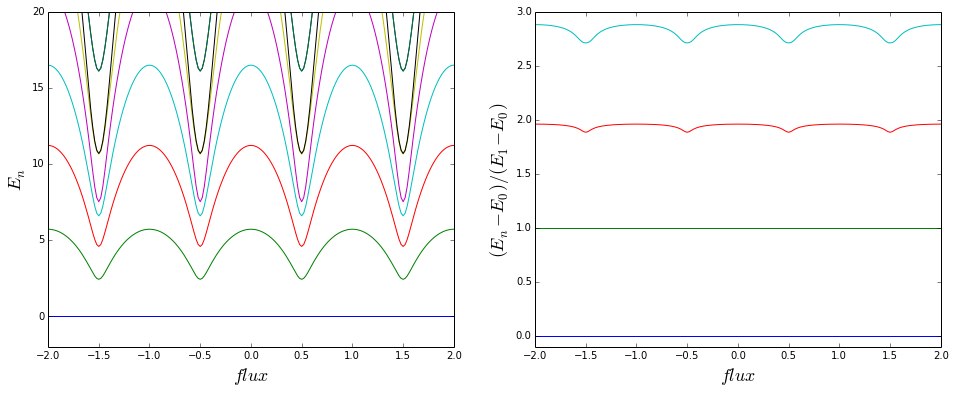

In [7]:
plot_energies(flux_vec, energies);

In [8]:
print "Max E_ge: " + str(max(energies[:,1]-energies[:,0])/(2*pi)) + " GHz"
print "Min E_ge: " + str(min(energies[:,1]-energies[:,0])/(2*pi)) + " GHz"
print "Max E_ef: " + str(max(energies[:,2]-energies[:,1])/(2*pi)) + " GHz"
print "Min E_ef: " + str(min(energies[:,2]-energies[:,1])/(2*pi)) + " GHz"

Max E_ge: 5.72553444958 GHz
Min E_ge: 2.43505112152 GHz
Max E_ef: 5.5075021152 GHz
Min E_ef: 2.15905663052 GHz


### Jaynes-Cummings

$H = \omega_c a^\dagger a + \Sigma \omega_{qi}\left|i\right\rangle\left\langle i\right| + \Sigma g_{ij}(a^\dagger + a)\left|i\right\rangle\left\langle j\right|$

$H \approx \omega_c a^\dagger a + \Sigma \omega_{qi}\left|i\right\rangle\left\langle i\right| + g(a^\dagger + a)(b^\dagger + b)$

### Vacuum Rabi

In [9]:
f_c = 2*pi*5.0 #GHz
g = 2*pi*0.1 #GHz
N_q = 5 #number of qubit modes
N_r = 5 #number of resonator modes

e_array= zeros(N_q)
e_array[1] = 1
e_matrix = Qobj(diag(e_array))

f_array= zeros(N_q)
f_array[2] = 1
f_matrix = Qobj(diag(f_array))

h_array= zeros(N_q)
h_array[3] = 1
h_matrix = Qobj(diag(h_array))

e = tensor(qeye(N_r),e_matrix)
f = tensor(qeye(N_r),f_matrix)
h = tensor(qeye(N_r),h_matrix)


In [10]:
vr_energies=[]
vr_vectors=[]
for n in range(len(flux_vec)):
    f_q = Qobj(diag(energies[n,0:N_q]-energies[n,0]))
    a = tensor(destroy(N_r),qeye(N_q))
    b = tensor(qeye(N_r),destroy(N_q))
    H = f_c*a.dag()*a + tensor(qeye(N_r),f_q) + g*(a.dag() + a)*(b.dag()+b)
    vr_energies.append(H.eigenstates()[0])
    vr_vectors.append(H.eigenstates()[1])
vr_energies=array(vr_energies)

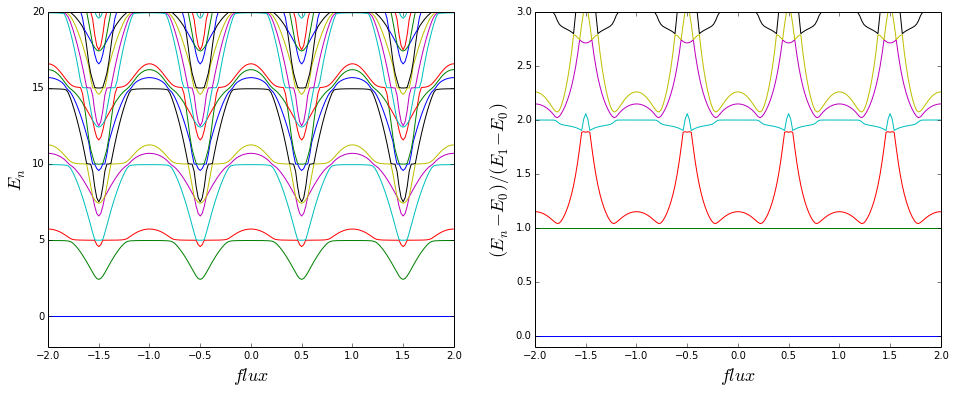

In [11]:
plot_energies(flux_vec, vr_energies);

In [19]:
# print energies[100,0:N_q]-energies[100,0]
op_pt=85
f_q_op = Qobj(diag(energies[op_pt,0:N_q]-energies[op_pt,0]))
print "Operating E_ge: " + str((energies[op_pt,1]-energies[op_pt,0])/(2*pi)) + " GHz"

a = tensor(destroy(N_r),qeye(N_q))
b = tensor(qeye(N_r),destroy(N_q))

H_op = f_c*a.dag()*a + tensor(qeye(N_r),f_q_op) + g*(a.dag() + a)*(b.dag()+b)

# print H_op.eigenstates()[1][1]*H_op.eigenstates()[1][1].dag()

Operating E_ge: 4.4226522883 GHz


### Dissipation

In [20]:
c_ops = []

T1_r = 1000.0 #ns
T1_q = 4000.0 #ns
T2_q = 1200.0 #ns

# cavity relaxation
kappa = 1/T1_r
c_ops.append(sqrt(kappa) * a)

# qubit relaxation
gamma = 1/T1_q
c_ops.append(sqrt(gamma) * b)

## Master equation solver

### Sideband

In [22]:
N=100
Ec=2*pi*0.2 #GHz
Ej=2*pi*20 #GHz
d=0.5

In [23]:
flux_vec_fine = np.linspace(0, 0.5, 10001)
energies = array([hamiltonian(Ec, Ej, d, N, flux).eigenenergies() for flux in flux_vec_fine])

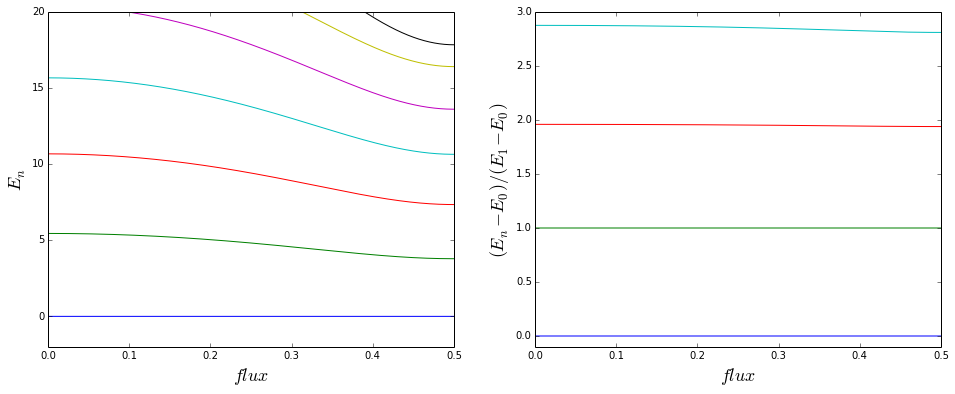

In [24]:
plot_energies(flux_vec_fine, energies);

In [25]:
print "Max E_ge: " + str(max(energies[:,1]-energies[:,0])/(2*pi)) + " GHz"
print "Min E_ge: " + str(min(energies[:,1]-energies[:,0])/(2*pi)) + " GHz"
print "Max E_ef: " + str(max(energies[:,2]-energies[:,1])/(2*pi)) + " GHz"
print "Min E_ef: " + str(min(energies[:,2]-energies[:,1])/(2*pi)) + " GHz"

Max E_ge: 5.44902710743 GHz
Min E_ge: 3.78838378487 GHz
Max E_ef: 5.22992825653 GHz
Min E_ef: 3.55853917902 GHz


In [26]:
def find_nearest(array,value):
    return min(range(len(array)), key=lambda i: abs(array[i]-value))

In [27]:
def find_index(array,value):
    step = array[1]-array[0]
    index = ((value - array[0])/step).astype(int64)
    return index

In [28]:
def get_energy_by_flux(E,f_v,flux,N_q):
#     i = find_nearest(f_v,flux)
    i = find_index(f_v,flux)
    return (E[i,:N_q]-E[i,0])

In [29]:
def get_jc_H_by_flux(E,f_v,flux,N_q,N_r):
    f_q =  Qobj(diag(get_energy_by_flux(E,f_v,flux,N_q)))
    a = tensor(destroy(N_r),qeye(N_q))
    b = tensor(qeye(N_r),destroy(N_q))
    H = f_c*a.dag()*a + tensor(qeye(N_r),f_q) + g*(a.dag() + a)*(b.dag()+b)
    return H

In [30]:
print get_energy_by_flux(energies,flux_vec_fine,0.2,N_q)/(2*pi)
# print get_jc_H_by_flux(energies,flux_vec_fine,0.1,N_q,N_r)/(2*pi)

[  0.           5.03971055   9.85848645  14.43805752  18.75352698]


### Master Equation Solver

$H_{sb0} = \omega_c a^\dagger a + g(a^\dagger + a)(b^\dagger + b)$

$H_{sb} \approx \omega_{Qge}(t)\left|1\right\rangle\left\langle 1\right| +  \omega_{Qef}(t)\left|2\right\rangle\left\langle 2\right| +  \omega_{Qfh}(t)\left|3\right\rangle\left\langle 3\right|$

In [31]:
H_SB0 = f_c*a.dag()*a + g*(a.dag() + a)*(b.dag()+b)

In [32]:
def H_SB_e_coeff(t,args):
    eps = args['epsilon']
    freq = args['freq']
    flux_0 = args['flux_0']
    
    flux = flux_0 + eps * sin(2*pi*freq*t)
    E_tSB = get_energy_by_flux(energies,flux_vec_fine,flux,N_q)
#     print E_tSB[1]-E_tSB[0]
    return E_tSB[1]-E_tSB[0]
def H_SB_f_coeff(t,args):
    eps = args['epsilon']
    freq = args['freq']
    flux_0 = args['flux_0']
    
    flux = flux_0 + eps * sin(2*pi*freq*t)
    E_tSB = get_energy_by_flux(energies,flux_vec_fine,flux,N_q)
#     print E_tSB[2]-E_tSB[0]
    return E_tSB[2]-E_tSB[0]
def H_SB_h_coeff(t,args):
    eps = args['epsilon']
    freq = args['freq']
    flux_0 = args['flux_0']
    
    flux = flux_0 + eps * sin(2*pi*freq*t)
    E_tSB = get_energy_by_flux(energies,flux_vec_fine,flux,N_q)
#     print E_tSB[3]-E_tSB[0]
    return E_tSB[3]-E_tSB[0]

In [33]:
tlist = linspace(0.0,100.0,1001)

H_t = [H_SB0, [e,H_SB_e_coeff], [f,H_SB_f_coeff], [h,H_SB_h_coeff]]
flux_0 = 0.3
E_0 = get_energy_by_flux(energies,flux_vec_fine,flux_0,N_q)
f_q = Qobj(diag(E_0[0:N_q]-E_0[0]))
# print f_q
a = tensor(destroy(N_r),qeye(N_q))
b = tensor(qeye(N_r),destroy(N_q))
H = f_c*a.dag()*a + tensor(qeye(N_r),f_q) + g*(a.dag() + a)*(b.dag()+b)

print "Eigenenergies:"
print (H.eigenenergies()-H.eigenenergies()[0])/(2*pi)
print "Difference in Eigenenergies:"
print (H.eigenenergies()[1:]-H.eigenenergies()[:-1])/(2*pi)


Eigenenergies:
[  0.           4.54598823   5.02104102   8.88252118   9.55321636
  10.04169282  12.97908083  13.88462373  14.56062194  15.06199009
  16.80649151  17.97881933  18.88684062  19.56912239  20.08621194
  21.77784737  22.97798538  23.8972705   24.68507956  26.75005697
  27.98621579  29.04610394  31.73098145  33.15298423  36.8586326 ]
Difference in Eigenenergies:
[ 4.54598823  0.47505278  3.86148017  0.67069518  0.48847646  2.93738801
  0.9055429   0.67599822  0.50136814  1.74450143  1.17232782  0.90802129
  0.68228177  0.51708955  1.69163543  1.200138    0.91928512  0.78780906
  2.06497741  1.23615883  1.05988815  2.68487751  1.42200278  3.70564837]


ge frequency: 4.56917055816 GHz
Mean modulated ge frequency: 4.56834101461 GHz
DC offset: -0.829543550026 MHz


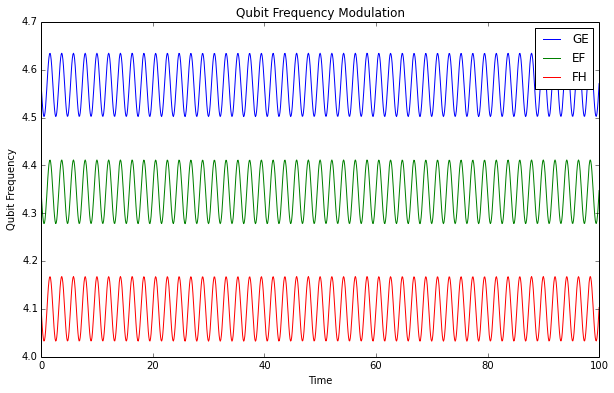

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

H_SB_e_v=[]
H_SB_f_v=[]
H_SB_h_v=[]
args = {'epsilon': 2*pi*0.002,'freq':(H.eigenenergies()[2]-H.eigenenergies()[1])/(2*pi),'flux_0':flux_0}
for ii, t in enumerate(tlist):
    H_SB_e_v.append(H_SB_e_coeff(t,args)/(2*pi))
    H_SB_f_v.append((H_SB_f_coeff(t,args)-H_SB_e_coeff(t,args))/(2*pi))
    H_SB_h_v.append((H_SB_h_coeff(t,args)-H_SB_f_coeff(t,args))/(2*pi))
axes.plot(tlist,H_SB_e_v, label="GE")
axes.plot(tlist,H_SB_f_v, label="EF")
axes.plot(tlist,H_SB_h_v, label="FH")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Qubit Frequency')
axes.set_title('Qubit Frequency Modulation')
print "ge frequency: " + str(H_SB_e_coeff(0,args)/(2*pi)) + " GHz"
print "Mean modulated ge frequency: " + str(mean(H_SB_e_v)) + " GHz"
print "DC offset: " + str((mean(H_SB_e_v)-H_SB_e_coeff(0,args)/(2*pi))*1000.0) + " MHz"


### Starting at |e,0>

In [35]:
tlist = linspace(0.0,1000.0,1001)
m1= H.eigenstates()[1][1]*H.eigenstates()[1][1].dag()
m2 = H.eigenstates()[1][2]*H.eigenstates()[1][2].dag()
psi0 = m1 # start in ground cavity and excited transmon

args = {'epsilon': 2*pi*0.001,'freq':(H.eigenenergies()[2]-H.eigenenergies()[1])/(2*pi),'flux_0':flux_0}
output = mesolve(H_t, psi0, tlist, c_ops, [m2, m1],args=args,options=Odeoptions(nsteps=1000),progress_bar=True)

10.1%. Run time:  20.82s. Est. time left: 00:00:03:05
20.1%. Run time:  41.67s. Est. time left: 00:00:02:45
30.1%. Run time:  62.53s. Est. time left: 00:00:02:25
40.1%. Run time:  83.30s. Est. time left: 00:00:02:04
50.0%. Run time: 104.08s. Est. time left: 00:00:01:43
60.0%. Run time: 124.76s. Est. time left: 00:00:01:23
70.0%. Run time: 145.47s. Est. time left: 00:00:01:02
80.0%. Run time: 166.38s. Est. time left: 00:00:00:41
90.0%. Run time: 187.08s. Est. time left: 00:00:00:20
Total run time: 207.58s


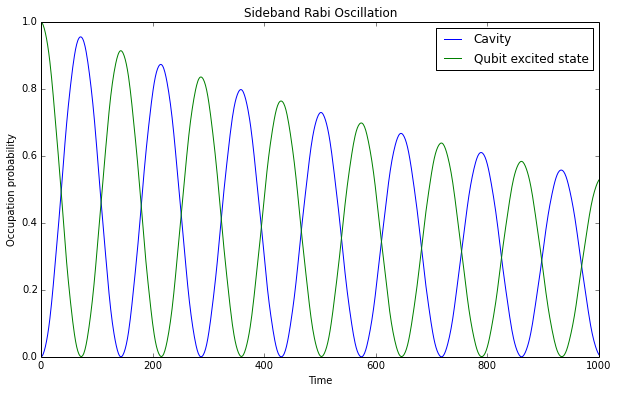

In [36]:
n_c_sideband_rabi = output.expect[0]
n_q_sideband_rabi = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(tlist, n_c_sideband_rabi, label="Cavity")
axes.plot(tlist, n_q_sideband_rabi, label="Qubit excited state")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Sideband Rabi Oscillation')

### Starting at |g,1> state

In [ ]:
m1= H.eigenstates()[1][1]*H.eigenstates()[1][1].dag()
m2 = H.eigenstates()[1][2]*H.eigenstates()[1][2].dag()
psi0 = m2 # start in ground cavity and excited transmon

args = {'epsilon': 2*pi*0.002,'freq':(H.eigenenergies()[2]-H.eigenenergies()[1])/(2*pi),'flux_0':flux_0}
output = mesolve(H_t, psi0, tlist, c_ops, [m2, m1],args=args,options=Odeoptions(nsteps=1000))

In [ ]:
n_c_sideband_rabi = output.expect[0]
n_q_sideband_rabi = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(tlist, n_c_sideband_rabi, label="Cavity")
axes.plot(tlist, n_q_sideband_rabi, label="Qubit excited state")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_ylim(0,1)
axes.set_title('Sideband Rabi Oscillation')

### Chevron, starting at |e,0>

In [ ]:
delta = linspace(-.025*pi,.025*pi,26)
n_c = []
n_q = []
psi0 = m1 # start in ground cavity and excited transmon
for d in delta:
   args = {'epsilon': 2*pi*0.002,'freq':(H.eigenenergies()[2]-H.eigenenergies()[1]+d)/(2*pi),'flux_0':flux_0}
   output = mesolve(H_t, psi0, tlist, [], [m2, m1],args=args,options=Odeoptions(nsteps=1000))
   n_c.append(output.expect[0])
   n_q.append(output.expect[1])

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(121, title="Cavity")

plt.pcolormesh(tlist,delta/pi, array(n_c))
plt.xlim(tlist[0],tlist[-1])
plt.ylim(delta[0]/pi,delta[-1]/pi)
plt.xlabel('Time')
plt.ylabel('Detuning')

plt.subplot(122, title="Qubit")

plt.pcolormesh(tlist,delta/pi, array(n_q))
plt.xlim(tlist[0],tlist[-1])
plt.ylim(delta[0]/pi,delta[-1]/pi)
plt.xlabel('Time')
plt.ylabel('Detuning')

In [ ]:
delta = linspace(-.05*pi,.05*pi,51)
n_c = []
n_q = []
psi0 = m1 # start in ground cavity and excited transmon
for d in delta:
   print d
   args = {'epsilon': 2*pi*0.001,'freq':(H.eigenenergies()[2]-H.eigenenergies()[1]+d)/(2*pi),'flux_0':flux_0}
   output = mesolve(H_t, psi0, tlist, c_ops, [m2, m1],args=args,options=Odeoptions(nsteps=5000))
   n_c.append(output.expect[0])
   n_q.append(output.expect[1])

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(121, title="Cavity")

plt.pcolormesh(tlist,delta/pi, array(n_c))
plt.xlim(tlist[0],tlist[-1])
plt.ylim(delta[0]/pi,delta[-1]/pi)
plt.xlabel('Time')
plt.ylabel('Detuning')

plt.subplot(122, title="Qubit")

plt.pcolormesh(tlist,delta/pi, array(n_q))
plt.xlim(tlist[0],tlist[-1])
plt.ylim(delta[0]/pi,delta[-1]/pi)
plt.xlabel('Time')
plt.ylabel('Detuning')